# **Transforming Natural Language into SQL Queries**

We begin by importing pandas which is the library we need to read and analyse our data. With this, we continue by importing the file we'll be working with "train_spider.json".

In [1]:
import pandas as pd

df = pd.read_json('train_spider.json')

Furthermore, we print the features the file contains and we make sure they are all the same type if not we´d need to convert them. Yet, we observe below with the command "df.types" that we are dwaling with nothing but objects so we leave that alone. In the features we can observe, the content about the natural language question under the field “question”, about its tokens under “question-toks”, and the database id to which it is addressed under “db-id”. Additionally, the columns “query” and “query-toks” contain information about each SQL query per question and its token correspondingly.

In [2]:
df.head()

,db_id,query,query_toks,query_toks_no_value,question,question_toks,sql
0,department_management,SELECT count(*) FROM head WHERE age > 56,"[SELECT, count, (, *, ), FROM, head, WHERE, ag...","[select, count, (, *, ), from, head, where, ag...",How many heads of the departments are older th...,"[How, many, heads, of, the, departments, are, ...","{'from': {'table_units': [['table_unit', 1]], ..."
1,department_management,"SELECT name , born_state , age FROM head ORD...","[SELECT, name, ,, born_state, ,, age, FROM, he...","[select, name, ,, born_state, ,, age, from, he...","List the name, born state and age of the heads...","[List, the, name, ,, born, state, and, age, of...","{'from': {'table_units': [['table_unit', 1]], ..."
2,department_management,"SELECT creation , name , budget_in_billions ...","[SELECT, creation, ,, name, ,, budget_in_billi...","[select, creation, ,, name, ,, budget_in_billi...","List the creation year, name and budget of eac...","[List, the, creation, year, ,, name, and, budg...","{'from': {'table_units': [['table_unit', 0]], ..."
3,department_management,"SELECT max(budget_in_billions) , min(budget_i...","[SELECT, max, (, budget_in_billions, ), ,, min...","[select, max, (, budget_in_billions, ), ,, min...",What are the maximum and minimum budget of the...,"[What, are, the, maximum, and, minimum, budget...","{'from': {'table_units': [['table_unit', 0]], ..."
4,department_management,SELECT avg(num_employees) FROM department WHER...,"[SELECT, avg, (, num_employees, ), FROM, depar...","[select, avg, (, num_employees, ), from, depar...",What is the average number of employees of the...,"[What, is, the, average, number, of, employees...","{'from': {'table_units': [['table_unit', 0]], ..."


In [3]:
df.dtypes

db_id                  object
query                  object
query_toks             object
query_toks_no_value    object
question               object
question_toks          object
sql                    object
dtype: object

Since, we have a very large database we choose to examine only the first 1000 instances for a simpler and more efficient analysis.

In [6]:
df.iloc[:100,:]

,db_id,query,query_toks,query_toks_no_value,question,question_toks,sql
0,department_management,SELECT count(*) FROM head WHERE age > 56,"[SELECT, count, (, *, ), FROM, head, WHERE, ag...","[select, count, (, *, ), from, head, where, ag...",How many heads of the departments are older th...,"[How, many, heads, of, the, departments, are, ...","{'from': {'table_units': [['table_unit', 1]], ..."
1,department_management,"SELECT name , born_state , age FROM head ORD...","[SELECT, name, ,, born_state, ,, age, FROM, he...","[select, name, ,, born_state, ,, age, from, he...","List the name, born state and age of the heads...","[List, the, name, ,, born, state, and, age, of...","{'from': {'table_units': [['table_unit', 1]], ..."
2,department_management,"SELECT creation , name , budget_in_billions ...","[SELECT, creation, ,, name, ,, budget_in_billi...","[select, creation, ,, name, ,, budget_in_billi...","List the creation year, name and budget of eac...","[List, the, creation, year, ,, name, and, budg...","{'from': {'table_units': [['table_unit', 0]], ..."
3,department_management,"SELECT max(budget_in_billions) , min(budget_i...","[SELECT, max, (, budget_in_billions, ), ,, min...","[select, max, (, budget_in_billions, ), ,, min...",What are the maximum and minimum budget of the...,"[What, are, the, maximum, and, minimum, budget...","{'from': {'table_units': [['table_unit', 0]], ..."
4,department_management,SELECT avg(num_employees) FROM department WHER...,"[SELECT, avg, (, num_employees, ), FROM, depar...","[select, avg, (, num_employees, ), from, depar...",What is the average number of employees of the...,"[What, is, the, average, number, of, employees...","{'from': {'table_units': [['table_unit', 0]], ..."
...,...,...,...,...,...,...,...
95,student_assessment,SELECT course_name FROM courses ORDER BY cours...,"[SELECT, course_name, FROM, courses, ORDER, BY...","[select, course_name, from, courses, order, by...",List the names of courses in alphabetical order?,"[List, the, names, of, courses, in, alphabetic...","{'from': {'table_units': [['table_unit', 3]], ..."
96,student_assessment,SELECT course_name FROM courses ORDER BY cours...,"[SELECT, course_name, FROM, courses, ORDER, BY...","[select, course_name, from, courses, order, by...",What are the names of the courses in alphabeti...,"[What, are, the, names, of, the, courses, in, ...","{'from': {'table_units': [['table_unit', 3]], ..."
97,student_assessment,SELECT first_name FROM people ORDER BY first_name,"[SELECT, first_name, FROM, people, ORDER, BY, ...","[select, first_name, from, people, order, by, ...",List the first names of people in alphabetical...,"[List, the, first, names, of, people, in, alph...","{'from': {'table_units': [['table_unit', 1]], ..."
98,student_assessment,SELECT first_name FROM people ORDER BY first_name,"[SELECT, first_name, FROM, people, ORDER, BY, ...","[select, first_name, from, people, order, by, ...",What are the first names of the people in alph...,"[What, are, the, first, names, of, the, people...","{'from': {'table_units': [['table_unit', 1]], ..."


A way we can propose to manage the data later on is by n-grams which is why below we illustrate the frequency of each question per id as seen on Figure 1. Keeping this in mind, we can later implement this idea onto the recurrent neural network (RNN) encoder-decoder model we´ll develop. Furthermore, it is also useful to select the 1000 instances we need.  

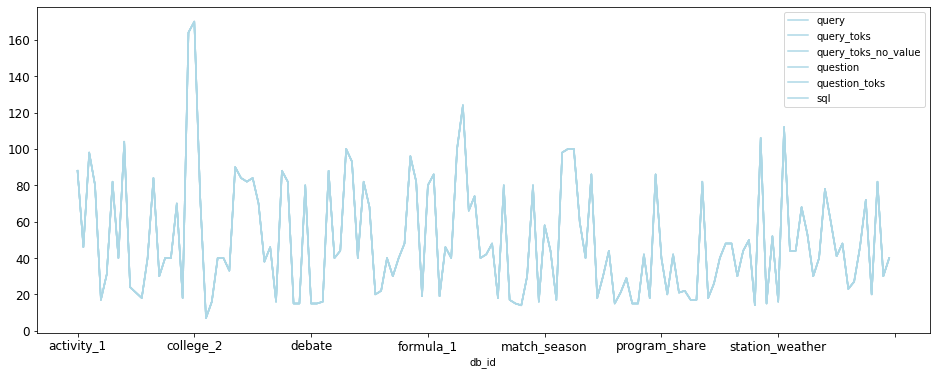

In [30]:
df.groupby(['db_id']).count().plot(fontsize = 12, color ='lightblue', figsize = (16,6))